<a href="https://colab.research.google.com/github/intel-analytics/analytics-zoo/blob/master/docs/docs/colab-notebook/chronos/chronos_autots_nyc_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


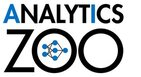
---

##### Copyright 2018 Analytics Zoo Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Analytics Zoo**

You can install the latest pre-release version using `pip install --pre --upgrade analytics-zoo`. 

In [ ]:
# Install latest pre-release version of Analytics Zoo
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo[automl]

## **Unsupervised Anomaly Detection using Chronos Anomaly Detector**

In this guide we will demonstrate how to use Chronos Anomaly Detector for automated time seires forecasting.

## **Step 0: Prepare dataset**
For demonstration, we use the publicly available cluster trace data cluster-trace-v2018 of Alibaba Open Cluster Trace Program. You can find the dataset introduction [here](https://github.com/alibaba/clusterdata/blob/master/cluster-trace-v2018/trace_2018.md). In particular, we use machine usage data to demonstrate anomaly detection, you can download the separate data file directly with [machine_usage](http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz).

In [ ]:
# download the dataset
!wget http://clusterdata2018pubcn.oss-cn-beijing.aliyuncs.com/machine_usage.tar.gz
!tar -zxvf machine_usage.tar.gz

In [ ]:
!grep m_1932 machine_usage.csv > m_1932.csv

## Step 1: Data Preprocessing

In [1]:
import pandas as pd
df = pd.read_csv("m_1932.csv",
                 header=None,
                 usecols=[1,2,3],
                 names=["time_step", "cpu_usage","mem_usage"])
df.sort_values(by="time_step", inplace=True)
df.reset_index(inplace=True)
df["time_step"] = pd.to_datetime(df["time_step"], unit='s', origin=pd.Timestamp('2018-01-01'))
df.head()

,index,time_step,cpu_usage,mem_usage
0,32463,2018-01-01 00:56:50,19,90
1,10107,2018-01-01 00:57:00,20,91
2,31022,2018-01-01 00:57:10,20,91
3,41496,2018-01-01 00:57:20,20,91
4,16925,2018-01-01 00:57:30,20,91


In [2]:
from zoo.chronos.data import TSDataset

tsdata = TSDataset.from_pandas(df, dt_col="time_step", target_col="cpu_usage")
df = tsdata.resample(interval='1min')\
           .impute(mode="linear")\
           .to_pandas()

## AD Usage

In [3]:
import matplotlib.pyplot as plt

In [4]:
from zoo.chronos.model.anomaly import DBScanDetector

ad = DBScanDetector(eps=0.1, min_samples=6)
ad.fit(df['cpu_usage'].to_numpy())
anomaly_indexes = ad.anomaly_indexes()

## plot

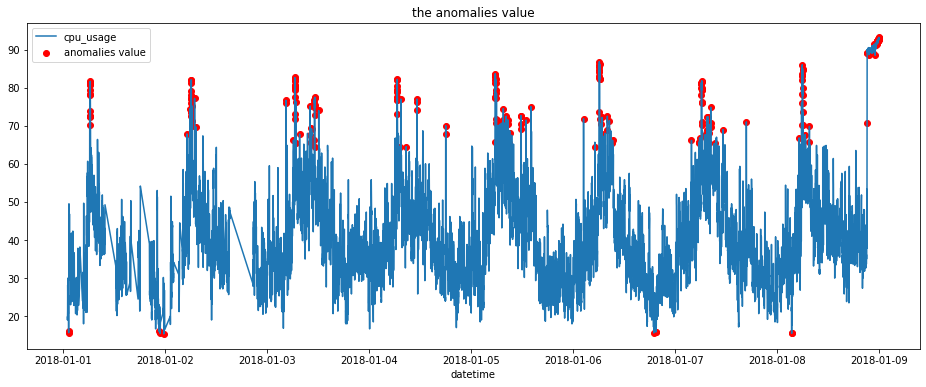

In [6]:
plt.figure(figsize=(16,6))
plt.plot(df.time_step, df.cpu_usage, label='cpu_usage')
plt.scatter(df.time_step[anomaly_indexes],
            df.cpu_usage[anomaly_indexes],
            color='red', label='anomalies value')

plt.title('the anomalies value')
plt.xlabel('datetime')
plt.legend(loc='upper left')
plt.show()